<a href="https://colab.research.google.com/github/keeprich/AI-Trading-Bot/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project work

# Data collecttion

# Building model

# Import Libraries

In [1]:
!pip install oandapyV20
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=ac55faaf2d3bf1feb79f02927fa79831320af7fe5b3efb1d7b24bb16b1e6dca7
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


No saved model found. Training a new model...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.1111 - val_loss: 0.0062
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0119 - val_loss: 0.0050
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0081 - val_loss: 0.0045
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0085 - val_loss: 0.0047
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 9/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 10/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0053 - val_loss: 0.0073
Epoch 11/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 12/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0047 - val

Model trained and saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Model Evaluation - MAE: 0.00015956654686834811, MSE: 4.4882230960180176e-08, RMSE: 0.00021185426821327007, R2: 0.804459562890819


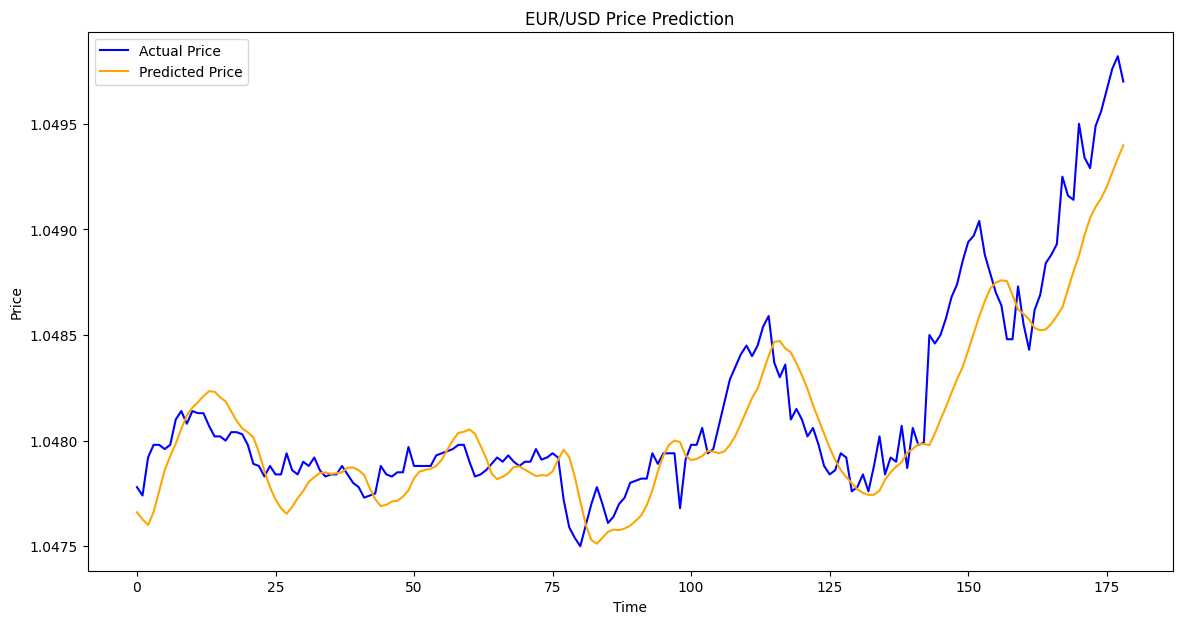

In [2]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Step 1: Fetch Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    """
    Fetch historical price data from OANDA API.
    """
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Step 2: Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Step 3: Preprocess Data
def preprocess_data(data, target_column, sequence_length=60):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, target_column])    # Target value
    X, y = np.array(X), np.array(y)

    return X, y, scaler

# Step 4: Build and Train LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 5: Model Evaluation
def evaluate_model(X_test, y_test, model, scaler, target_column, feature_columns):
    # Make predictions
    y_pred = model.predict(X_test)

    # Rescale predictions and actual values back to the original scale
    temp_array = np.zeros((y_pred.shape[0], len(feature_columns)))
    temp_array[:, target_column] = y_pred.ravel()
    predictions = scaler.inverse_transform(temp_array)[:, target_column]

    temp_array = np.zeros((y_test.shape[0], len(feature_columns)))
    temp_array[:, target_column] = y_test.ravel()
    actual = scaler.inverse_transform(temp_array)[:, target_column]

    # Calculate error metrics
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)

    print(f"Model Evaluation - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

    # Plot results
    plot_results(actual, predictions, title="EUR/USD Price Prediction")

# Step 6: Plot Results
def plot_results(actual, predicted, title="Price Prediction"):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label="Actual Price", color="blue")
    plt.plot(predicted, label="Predicted Price", color="orange")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Step 7: Main Workflow
if __name__ == "__main__":
    # Fetch data from OANDA
    data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=1000)

    if data.empty:
        print("No data fetched. Exiting.")
    else:
        # Add indicators to the dataset
        data['RSI'] = calculate_rsi(data['close'])
        data['SMA_50'] = calculate_sma(data['close'], window=50)
        data['EMA_50'] = calculate_ema(data['close'], window=50)
        data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

        # Drop NaN values caused by rolling calculations
        data.dropna(inplace=True)

        # Preprocess data for LSTM
        feature_columns = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
        target_column = 0  # Predict 'close' price
        X, y, scaler = preprocess_data(data[feature_columns], target_column)

        # Split into train and test sets
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Check if the model already exists
        try:
            model = load_model("oanda_lstm_trading_modelm1_m1.h5")
            print("Model loaded successfully!")
        except:
            # Build and train the LSTM model if no saved model exists
            print("No saved model found. Training a new model...")
            model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
            model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
            model.save("oanda_lstm_trading_modelm1_m1.h5")
            print("Model trained and saved successfully!")

        # Evaluate model performance on test data
        evaluate_model(X_test, y_test, model, scaler, target_column, feature_columns)


# M1

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 39/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 40/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0019 - val_loss: 0.0022

WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.

Model trained and saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
Model Evaluation - MAE: 0.0003353428851009669, MSE: 1.8580762911399814e-07, RMSE: 0.00043105409070556117, R2: 0.8694427197392814


# M1_M30
Epoch 39/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 40/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0023 - val_loss: 0.0015

WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.

Model trained and saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Model Evaluation - MAE: 0.0015525568204552145, MSE: 4.44896269036865e-06, RMSE: 0.002109256430680881, R2: 0.6921606003097449


#M30_M30

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 39/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 40/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0018 - val_loss: 0.0015

WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.

Model trained and saved successfully!

WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7cd654fe3760> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Model Evaluation - MAE: 0.0015372978533529813, MSE: 4.397996434742331e-06, RMSE: 0.002097140060831019, R2: 0.6914091372440248


# Back testing

# m1_m1 with M30 backtest

```
`# This is formatted as code`
```

data

In [3]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import time

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
TRANSACTION_COST = 0.0001  # Spread or transaction cost (0.01% per trade)
SLIPPAGE = 0.0001  # 1 pip slippage for both buy/sell orders
STARTING_BALANCE = 100000  # Starting capital for backtest
UNITS = 1000  # Units per trade (can be adjusted)

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="M30", count=500):
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Process Data for Predictions
def preprocess_data(data, target_column, sequence_length=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, target_column])    # Target value
    return np.array(X), np.array(y), scaler

# Backtesting Function
def backtest():
    # Fetch historical data
    data = fetch_oanda_data(instrument="EUR_USD", granularity="M30", count=500)
    if data.empty:
        print("No data fetched for backtesting. Exiting.")
        return

    # Preprocessing data
    data['RSI'] = calculate_rsi(data['close'])
    data['SMA_50'] = calculate_sma(data['close'], window=50)
    data['EMA_50'] = calculate_ema(data['close'], window=50)
    data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

    # Drop NaN values
    data.dropna(inplace=True)

    # Prepare features and target
    feature_columns = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
    target_column = 0  # Predict 'close' price
    X, y, scaler = preprocess_data(data[feature_columns], target_column)

    # Load or Train the Model
    try:
        model = load_model("oanda_lstm_trading_modelm1_m1.h5")
        print("Model loaded successfully!")
    except:
        print("No model found. Please train the model first.")
        return

    # Simulating Trades
    balance = STARTING_BALANCE
    position = None
    trade_entry_price = None
    for i in range(len(X)):
        # Get predicted trend for the current time step
        prediction = model.predict(X[i].reshape(1, X[i].shape[0], X[i].shape[1]))

        # Get current price
        current_price = data['close'].iloc[i + 60]  # Ensure we get data aligned with predictions
        predicted_trend = prediction[0][0]
        print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

        # Check if there is an open position and close it based on profit/loss
        if position:
            # Check if stop-loss or take-profit is hit
            if position == "buy" and current_price >= trade_entry_price + (SLIPPAGE * 3):
                print(f"Take profit hit. Closing Buy at {current_price}")
                balance += (current_price - trade_entry_price) * UNITS - TRANSACTION_COST
                position = None
            elif position == "sell" and current_price <= trade_entry_price - (SLIPPAGE * 3):
                print(f"Take profit hit. Closing Sell at {current_price}")
                balance += (trade_entry_price - current_price) * UNITS - TRANSACTION_COST
                position = None
            elif current_price <= trade_entry_price - (SLIPPAGE * 3):  # Stop loss hit
                print(f"Stop loss hit. Closing position at {current_price}")
                balance -= (trade_entry_price - current_price) * UNITS + TRANSACTION_COST
                position = None

        # Open new position if none exists
        if not position:
            if predicted_trend > current_price:
                print(f"Buying at {current_price}")
                position = "buy"
                trade_entry_price = current_price
                balance -= trade_entry_price * UNITS + TRANSACTION_COST
            elif predicted_trend < current_price:
                print(f"Selling at {current_price}")
                position = "sell"
                trade_entry_price = current_price
                balance += trade_entry_price * UNITS - TRANSACTION_COST

    print(f"Final Balance after backtesting: {balance}")

# Main Execution
if __name__ == "__main__":
    backtest()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Predicted Trend: 0.7179574966430664, Current Price: 1.05426
Selling at 1.05426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Trend: 0.7223804593086243, Current Price: 1.05412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Trend: 0.7196720242500305, Current Price: 1.05402
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Trend: 0.7132499814033508, Current Price: 1.05376
Take profit hit. Closing Sell at 1.05376
Selling at 1.05376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Trend: 0.7064865231513977, Current Price: 1.05543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Trend: 0.7091192007064819, Current Price: 1.0557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Trend: 0.7181154489517212, Current Price: 1.05566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Trend: 0.7268601059913635, Current Price: 1.056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Trend: 0.7331902384757996, Current Price: 1.05698
1/1 ━━━━━━━━━━

# m1_m1 with H1 backtest


In [4]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import time

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
TRANSACTION_COST = 0.0001  # Spread or transaction cost (0.01% per trade)
SLIPPAGE = 0.0001  # 1 pip slippage for both buy/sell orders
STARTING_BALANCE = 100000  # Starting capital for backtest
UNITS = 1000  # Units per trade (can be adjusted)

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500):
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Process Data for Predictions
def preprocess_data(data, target_column, sequence_length=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, target_column])    # Target value
    return np.array(X), np.array(y), scaler

# Backtesting Function
def backtest():
    # Fetch historical data
    data = fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500)
    if data.empty:
        print("No data fetched for backtesting. Exiting.")
        return

    # Preprocessing data
    data['RSI'] = calculate_rsi(data['close'])
    data['SMA_50'] = calculate_sma(data['close'], window=50)
    data['EMA_50'] = calculate_ema(data['close'], window=50)
    data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

    # Drop NaN values
    data.dropna(inplace=True)

    # Prepare features and target
    feature_columns = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
    target_column = 0  # Predict 'close' price
    X, y, scaler = preprocess_data(data[feature_columns], target_column)

    # Load or Train the Model
    try:
        model = load_model("oanda_lstm_trading_modelm1_m1.h5")
        print("Model loaded successfully!")
    except:
        print("No model found. Please train the model first.")
        return

    # Simulating Trades
    balance = STARTING_BALANCE
    position = None
    trade_entry_price = None
    for i in range(len(X)):
        # Get predicted trend for the current time step
        prediction = model.predict(X[i].reshape(1, X[i].shape[0], X[i].shape[1]))

        # Get current price
        current_price = data['close'].iloc[i + 60]  # Ensure we get data aligned with predictions
        predicted_trend = prediction[0][0]
        print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

        # Check if there is an open position and close it based on profit/loss
        if position:
            # Check if stop-loss or take-profit is hit
            if position == "buy" and current_price >= trade_entry_price + (SLIPPAGE * 3):
                print(f"Take profit hit. Closing Buy at {current_price}")
                balance += (current_price - trade_entry_price) * UNITS - TRANSACTION_COST
                position = None
            elif position == "sell" and current_price <= trade_entry_price - (SLIPPAGE * 3):
                print(f"Take profit hit. Closing Sell at {current_price}")
                balance += (trade_entry_price - current_price) * UNITS - TRANSACTION_COST
                position = None
            elif current_price <= trade_entry_price - (SLIPPAGE * 3):  # Stop loss hit
                print(f"Stop loss hit. Closing position at {current_price}")
                balance -= (trade_entry_price - current_price) * UNITS + TRANSACTION_COST
                position = None

        # Open new position if none exists
        if not position:
            if predicted_trend > current_price:
                print(f"Buying at {current_price}")
                position = "buy"
                trade_entry_price = current_price
                balance -= trade_entry_price * UNITS + TRANSACTION_COST
            elif predicted_trend < current_price:
                print(f"Selling at {current_price}")
                position = "sell"
                trade_entry_price = current_price
                balance += trade_entry_price * UNITS - TRANSACTION_COST

    print(f"Final Balance after backtesting: {balance}")

# Main Execution
if __name__ == "__main__":
    backtest()


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
Predicted Trend: 0.893588662147522, Current Price: 1.08776
Selling at 1.08776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Trend: 0.8833649158477783, Current Price: 1.08774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Trend: 0.8755789399147034, Current Price: 1.08758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Trend: 0.8692309856414795, Current Price: 1.08754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Trend: 0.8661053776741028, Current Price: 1.08786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Trend: 0.8678066730499268, Current Price: 1.08808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Trend: 0.8799956440925598, Current Price: 1.08887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Trend: 0.8957322835922241, Current Price: 1.08918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Trend: 0.9138062000274658, Current Price: 1.08918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Trend: 0.934002161026001

# Predicted Trend: 0.20420321822166443, Current Price: 1.04705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Trend: 0.19325312972068787, Current Price: 1.04722
Final Balance after backtesting: 139412.64270000003

m1_m1
H1
H1

# Live trading

In [10]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.orders as orders
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
UNITS = 1000
TRADE_INTERVAL = 60  # Seconds
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']

# Visualization Data
price_history = []
predicted_trends = []
timestamps = []
trades = []

# Fetch Live Data
def fetch_live_data(instrument="EUR_USD", granularity="H1", count=100):
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching live data: {e}")
        return pd.DataFrame()

# Place Trade
def place_trade(action, instrument, units, price):
    print(f"{action.capitalize()} trade executed at {price}. Units: {units}.")
    trades.append({'action': action, 'price': price, 'timestamp': time.time()})

# Visualize Trades and Predictions
def visualize_trades():
    plt.figure(figsize=(14, 7))
    plt.plot(timestamps, price_history, label='Price', color='blue')
    plt.plot(timestamps, predicted_trends, label='Predicted Trend', color='orange')

    # Plot trades
    for trade in trades:
        color = 'green' if trade['action'] == 'buy' else 'red'
        plt.scatter(trade['timestamp'], trade['price'], color=color, label=f"{trade['action'].capitalize()} Trade", s=50)

    plt.title("Live Trading with Predictions and Trades")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main Live Trading Function
def live_trading():
    print("Loading model...")
    try:
        model = load_model("oanda_lstm_trading_modelm1_m1.h5")
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    scaler = MinMaxScaler()
    while True:
        try:
            # Fetch live data
            print("Fetching live data...")
            live_data = fetch_live_data(instrument="EUR_USD", granularity="H1", count=200)
            print(f"Fetched {len(live_data)} rows of raw data.")

            if live_data.empty or len(live_data) < 120:
                print("Insufficient raw data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Calculate indicators
            print("Calculating indicators...")
            live_data['RSI'] = calculate_rsi(live_data['close'])
            live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
            live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
            live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])
            live_data.dropna(inplace=True)

            print(f"Processed data after indicators: {len(live_data)} rows.")

            if len(live_data) < 60:
                print("Insufficient processed data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Scale and reshape input data
            features = live_data[FEATURE_COLUMNS].values
            print(f"Feature shape before scaling: {features.shape}")

            scaled_features = scaler.fit_transform(features)
            input_data = scaled_features[-60:].reshape(1, 60, len(FEATURE_COLUMNS))
            print(f"Input data shape for model: {input_data.shape}")

            # Predict the trend
            predicted_trend = model.predict(input_data)[0][0]
            current_price = live_data['close'].iloc[-1]
            print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

            # Trading logic (unchanged)

        except Exception as e:
            print(f"Error in live trading loop: {e}")

        # Wait for the next cycle
        print("Waiting for the next cycle...\n")
        time.sleep(TRADE_INTERVAL)


# Run Live Trading
if __name__ == "__main__":
    live_trading()


Loading model...
Model loaded successfully!
Fetching live data...
Fetched 200 rows of raw data.
Calculating indicators...
Processed data after indicators: 151 rows.
Feature shape before scaling: (151, 7)
Input data shape for model: (1, 60, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Predicted Trend: 0.396650105714798, Current Price: 1.04748
Waiting for the next cycle...

Fetching live data...
Fetched 200 rows of raw data.
Calculating indicators...
Processed data after indicators: 151 rows.
Feature shape before scaling: (151, 7)
Input data shape for model: (1, 60, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Trend: 0.3957195580005646, Current Price: 1.04728
Waiting for the next cycle...

Fetching live data...
Fetched 200 rows of raw data.
Calculating indicators...
Processed data after indicators: 151 rows.
Feature shape before scaling: (151, 7)
Input data shape for model: (1, 60, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Trend: 0.39637213945388794, Current Price: 1.04742
Wa

KeyboardInterrupt: 

In [16]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime
import time

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
INSTRUMENT = "EUR_USD"
GRANULARITY = "H1"  # Fetch M1 data
SEQUENCE_LENGTH = 60
TRADE_INTERVAL = 60  # 60 seconds
MAX_TRADES_PER_DAY = 10
TRANSACTION_COST = 0.0001
STARTING_BALANCE = 100000
UNITS = 1000

# Visualization Data
trade_log = []

# Fetch live data from OANDA
def fetch_live_data(instrument=INSTRUMENT, count=SEQUENCE_LENGTH + 100, granularity=GRANULARITY):
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]
        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })
        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching live data: {e}")
        return pd.DataFrame()

# Calculate indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Visualization
def visualize_trades(data, trade_log):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label='Price', color='blue')
    buy_signals = [trade for trade in trade_log if trade['action'] == 'buy']
    sell_signals = [trade for trade in trade_log if trade['action'] == 'sell']

    for trade in buy_signals:
        plt.scatter(trade['time'], trade['entry_price'], label='Buy', color='green', marker='^')

    for trade in sell_signals:
        plt.scatter(trade['time'], trade['entry_price'], label='Sell', color='red', marker='v')

    plt.title("Live Trades with Predicted Trends")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Place trade logic
def place_trade(action, instrument, current_price, stop_price, tp_price):
    trade_log.append({
        "time": datetime.now(),
        "action": action,
        "entry_price": current_price,
        "stop_price": stop_price,
        "tp_price": tp_price
    })
    print(f"{action.capitalize()} trade placed at {current_price}, SL: {stop_price}, TP: {tp_price}")

# Aggregate M1 data to M30
def aggregate_to_m30(df):
    try:
        df.set_index("time", inplace=True)
        m30_data = df.resample("30min").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last"
        }).dropna()
        m30_data.reset_index(inplace=True)
        return m30_data
    except Exception as e:
        print(f"Error during M30 aggregation: {e}")
        return pd.DataFrame()

# Live trading loop
def live_trading():
    # Load the trained model
    print("Loading model...")
    try:
        model = load_model("oanda_lstm_trading_modelm1_m1.h5")
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    daily_trade_count = 0
    last_trade_date = datetime.now().date()
    balance = STARTING_BALANCE

    while True:
        try:
            current_date = datetime.now().date()
            if current_date != last_trade_date:
                daily_trade_count = 0
                last_trade_date = current_date

            if daily_trade_count >= MAX_TRADES_PER_DAY:
                print(f"Max trades reached for {current_date}. Waiting for the next day...")
                time.sleep(TRADE_INTERVAL)
                continue

            print("Fetching live data...")
            live_data = fetch_live_data()
            if live_data.empty or len(live_data) < SEQUENCE_LENGTH:
                print("Insufficient raw data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            print("Calculating indicators...")
            m30_data = aggregate_to_m30(live_data)
            if m30_data.empty or len(m30_data) < SEQUENCE_LENGTH:
                print("Insufficient processed data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            m30_data['RSI'] = calculate_rsi(m30_data['close'])
            m30_data['SMA_50'] = calculate_sma(m30_data['close'], window=50)
            m30_data['EMA_50'] = calculate_ema(m30_data['close'], window=50)
            m30_data['BB_Mid'], m30_data['BB_Upper'], m30_data['BB_Lower'] = calculate_bollinger_bands(m30_data['close'])

            m30_data.dropna(inplace=True)
            if len(m30_data) < SEQUENCE_LENGTH:
                print("Insufficient processed data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            input_data = m30_data[['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']].values[-SEQUENCE_LENGTH:]
            input_data = input_data.reshape(1, SEQUENCE_LENGTH, 7)

            predicted_trend = model.predict(input_data)[0][0]
            current_price = m30_data['close'].iloc[-1]
            print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

            if predicted_trend > 0.6:
                stop_price = current_price - (0.005)
                tp_price = current_price + (0.015)
                place_trade("buy", INSTRUMENT, current_price, stop_price, tp_price)
                daily_trade_count += 1
            elif predicted_trend < 0.4:
                stop_price = current_price + (0.005)
                tp_price = current_price - (0.015)
                place_trade("sell", INSTRUMENT, current_price, stop_price, tp_price)
                daily_trade_count += 1
            else:
                print("Signal: Hold")

        except Exception as e:
            print(f"Error in live trading loop: {e}")

        print("Waiting for the next cycle...\n")
        time.sleep(TRADE_INTERVAL)

    visualize_trades(live_data, trade_log)

# Main Execution
if __name__ == "__main__":
    live_trading()


Loading model...
Model loaded successfully!
Fetching live data...
Calculating indicators...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Predicted Trend: 1.8707605600357056, Current Price: 1.04752
Buy trade placed at 1.04752, SL: 1.0425200000000001, TP: 1.06252
Waiting for the next cycle...

Fetching live data...
Calculating indicators...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Trend: 1.8707586526870728, Current Price: 1.04754
Buy trade placed at 1.04754, SL: 1.04254, TP: 1.0625399999999998
Waiting for the next cycle...

Fetching live data...
Calculating indicators...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Trend: 1.8707705736160278, Current Price: 1.04744
Buy trade placed at 1.04744, SL: 1.04244, TP: 1.0624399999999998
Waiting for the next cycle...

Fetching live data...
Calculating indicators...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Trend: 1.8707605600357056, Current Price: 1.04752
Buy trade placed at 1.04752, SL: 1.0425200000000001, TP: 1.06252
Waiting for the next cycle...



KeyboardInterrupt: 

# ML decision making

In [18]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import time
from datetime import datetime, timedelta

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
TRANSACTION_COST = 0.0001  # Spread or transaction cost (0.01% per trade)
SLIPPAGE = 0.0001  # 1 pip slippage for both buy/sell orders
STARTING_BALANCE = 100000  # Starting capital for backtest
UNITS = 1000  # Units per trade (can be adjusted)
MAX_TRADES_PER_DAY = 10  # Max trades per day
TRADE_INTERVAL = 60  # Time between trading cycles (in seconds)
SEQUENCE_LENGTH = 60  # Sequence length for model input
REQUIRED_FEATURES = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']  # Features for the model

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Process Data for Predictions
def preprocess_data(data, target_column, sequence_length=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, target_column])    # Target value
    return np.array(X), np.array(y), scaler

# Load or Train the Model
def load_or_train_model():
    try:
        model = load_model("oanda_lstm_trading_modelm1_m1.h5")
        print("Model loaded successfully!")
    except:
        print("No model found. Please train the model first.")
        return None
    return model

# Trade Execution Logic (Buy/Sell with SL/TP)
def place_trade(action, instrument, stop_price, tp_price):
    # Placeholder function to simulate trade placement
    print(f"Placing {action} trade for {instrument} at stop price {stop_price} and TP {tp_price}")
    # Actual trading code with OANDA API should go here

# Predict Trade Action: Buy, Sell, or Hold
def predict_trade_action(model, input_data):
    prediction = model.predict(input_data)
    action = np.argmax(prediction, axis=1)  # 0: Hold, 1: Buy, 2: Sell
    if action == 1:
        print("Action: Buy")
        return "buy"
    elif action == 2:
        print("Action: Sell")
        return "sell"
    else:
        print("Action: Hold")
        return "hold"

# Live Trading Loop
def live_trading():
    daily_trade_count = 0
    last_trade_date = datetime.now().date()

    while True:
        try:
            # Check if the maximum daily trades have been reached
            current_date = datetime.now().date()
            if current_date != last_trade_date:
                daily_trade_count = 0  # Reset daily trades on a new day
                last_trade_date = current_date

            if daily_trade_count >= MAX_TRADES_PER_DAY:
                print(f"Max trades reached for {current_date}. Waiting for the next day...")
                time.sleep(TRADE_INTERVAL)
                continue

            print("Fetching live data...")
            live_data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=SEQUENCE_LENGTH + 100)
            if live_data.empty or len(live_data) < SEQUENCE_LENGTH + 100:
                print("Insufficient raw data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Calculate indicators
            live_data['RSI'] = calculate_rsi(live_data['close'])
            live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
            live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
            live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])

            # Prepare model input
            input_data = live_data[REQUIRED_FEATURES].values[-SEQUENCE_LENGTH:]
            input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(REQUIRED_FEATURES))

            # Load model and predict trade action
            model = load_or_train_model()
            if model is None:
                break

            action = predict_trade_action(model, input_data)

            # Perform trade actions
            if action == "buy":
                current_price = live_data['close'].iloc[-1]
                stop_loss = current_price - 0.005  # Example SL
                take_profit = current_price + 0.015  # Example TP (1:3 ratio)
                place_trade(action="buy", instrument="EUR_USD", stop_price=stop_loss, tp_price=take_profit)
                daily_trade_count += 1
            elif action == "sell":
                current_price = live_data['close'].iloc[-1]
                stop_loss = current_price + 0.005  # Example SL
                take_profit = current_price - 0.015  # Example TP (1:3 ratio)
                place_trade(action="sell", instrument="EUR_USD", stop_price=stop_loss, tp_price=take_profit)
                daily_trade_count += 1

        except Exception as e:
            print(f"Error in live trading loop: {e}")

        print("Waiting for the next cycle...\n")
        time.sleep(TRADE_INTERVAL)

# Main Execution
if __name__ == "__main__":
    live_trading()


Fetching live data...


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Action: Hold
Waiting for the next cycle...

Fetching live data...


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Action: Hold
Waiting for the next cycle...

Fetching live data...


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Action: Hold
Waiting for the next cycle...

Fetching live data...


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Action: Hold
Waiting for the next cycle...

Fetching live data...


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Action: Hold
Waiting for the next cycle...

Fetching live data...


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Action: Hold
Waiting for the next cycle...



Fetching live data...
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Action: Hold
Waiting for the next cycle...



KeyboardInterrupt: 

In [9]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
TRANSACTION_COST = 0.0001  # Spread or transaction cost (0.01% per trade)
SLIPPAGE = 0.0001  # 1 pip slippage for both buy/sell orders
STARTING_BALANCE = 100000  # Starting capital for backtest
UNITS = 1000  # Units per trade (can be adjusted)
MAX_TRADES_PER_DAY = 10  # Max trades per day
TRADE_INTERVAL = 60  # Time between trading cycles (in seconds)
SEQUENCE_LENGTH = 60  # Sequence length for model input
REQUIRED_FEATURES = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']  # Features for the model

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Process Data for Predictions
def preprocess_data(data, target_column, sequence_length=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, target_column])    # Target value
    return np.array(X), np.array(y), scaler

# Load or Train the Model
def load_or_train_model():
    try:
        model = load_model("oanda_lstm_trading_modelm1_m1.h5")
        print("Model loaded successfully!")
    except:
        print("No model found. Please train the model first.")
        return None
    return model

# Trade Execution Logic (Buy/Sell with SL/TP)
def place_trade(action, instrument, stop_price, tp_price):
    # Placeholder function to simulate trade placement
    print(f"Placing {action} trade for {instrument} at stop price {stop_price} and TP {tp_price}")
    # Actual trading code with OANDA API should go here

# Predict Trade Action: Buy, Sell, or Hold
def predict_trade_action(model, input_data):
    prediction = model.predict(input_data)
    action = np.argmax(prediction, axis=1)  # 0: Hold, 1: Buy, 2: Sell
    if action == 1:
        print("Action: Buy")
        return "buy"
    elif action == 2:
        print("Action: Sell")
        return "sell"
    else:
        print("Action: Hold")
        return "hold"











# def plot_live_trading_data(data, predicted_trends, trades=[]):
#     plt.figure(figsize=(14, 7))

#     # Ensure data lengths are aligned for plotting
#     if len(data['time']) != len(predicted_trends):
#         print(f"Skipping visualization update: Data and predictions lengths mismatch ({len(data['time'])} vs {len(predicted_trends)})")
#         return

#     # Plot close price
#     plt.plot(data['time'], data['close'], label="Close Price", color='blue')

#     # Plot buy/sell signals
#     for trade in trades:
#         if trade['action'] == "buy":
#             plt.scatter(trade['time'], trade['price'], color='green', label="Buy Signal", marker='^', s=100)
#         elif trade['action'] == "sell":
#             plt.scatter(trade['time'], trade['price'], color='red', label="Sell Signal", marker='v', s=100)

#     # Plot predicted trends
#     plt.plot(data['time'], predicted_trends, label="Predicted Trend", color='orange', linestyle='--')

#     plt.title("Real-Time Trading with Predicted Trends")
#     plt.xlabel("Time")
#     plt.ylabel("Price")
#     plt.legend(loc='upper left')
#     plt.grid(True)
#     plt.show()

# # Ensure prediction is added after reshaping
# def predict_trade_action(model, input_data):
#     prediction = model.predict(input_data)
#     predicted_trend = prediction[0][0]
#     return predicted_trend

# # Live Trading Loop
# def live_trading():
#     daily_trade_count = 0
#     last_trade_date = datetime.now().date()
#     trades = []  # List to keep track of trades for visualization
#     predicted_trends = []  # List to keep track of predicted trends

#     while True:
#         try:
#             # Check if the maximum daily trades have been reached
#             current_date = datetime.now().date()
#             if current_date != last_trade_date:
#                 daily_trade_count = 0  # Reset daily trades on a new day
#                 last_trade_date = current_date

#             if daily_trade_count >= MAX_TRADES_PER_DAY:
#                 print(f"Max trades reached for {current_date}. Waiting for the next day...")
#                 time.sleep(TRADE_INTERVAL)
#                 continue

#             print("Fetching live data...")
#             live_data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=SEQUENCE_LENGTH + 100)
#             if live_data.empty or len(live_data) < SEQUENCE_LENGTH + 100:
#                 print("Insufficient raw data. Skipping this cycle.")
#                 time.sleep(TRADE_INTERVAL)
#                 continue

#             # Calculate indicators
#             live_data['RSI'] = calculate_rsi(live_data['close'])
#             live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
#             live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
#             live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])

#             # Drop NaN values caused by indicators
#             live_data.dropna(inplace=True)

#             # Ensure we have enough data for predictions
#             if len(live_data) < SEQUENCE_LENGTH:
#                 print("Insufficient processed data. Skipping this cycle.")
#                 time.sleep(TRADE_INTERVAL)
#                 continue

#             # Prepare model input
#             input_data = live_data[REQUIRED_FEATURES].values[-SEQUENCE_LENGTH:]
#             input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(REQUIRED_FEATURES))

#             # Load model and predict trend
#             model = load_or_train_model()
#             if model is None:
#                 break

#             predicted_trend = predict_trade_action(model, input_data)
#             predicted_trends.append(predicted_trend)  # Append the prediction

#             # Ensure predicted trends list matches live data length
#             while len(predicted_trends) > len(live_data):
#                 predicted_trends.pop(0)

#             current_price = live_data['close'].iloc[-1]
#             print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

#             # Determine trade action
#             action = None
#             if predicted_trend > 0.6:
#                 action = "buy"
#                 stop_price = current_price - 0.005
#                 tp_price = current_price + 0.015
#                 place_trade(action, instrument="EUR_USD", stop_price=stop_price, tp_price=tp_price)
#                 trades.append({'action': "buy", 'time': live_data['time'].iloc[-1], 'price': current_price})
#                 daily_trade_count += 1
#             elif predicted_trend < 0.4:
#                 action = "sell"
#                 stop_price = current_price + 0.005
#                 tp_price = current_price - 0.015
#                 place_trade(action, instrument="EUR_USD", stop_price=stop_price, tp_price=tp_price)
#                 trades.append({'action': "sell", 'time': live_data['time'].iloc[-1], 'price': current_price})
#                 daily_trade_count += 1
#             else:
#                 print("Action: Hold")

#             # Visualize the data
#             plot_live_trading_data(live_data, predicted_trends, trades)

#         except Exception as e:
#             print(f"Error in live trading loop: {e}")

#         # Wait for the next cycle
#         print("Waiting for the next cycle...\n")
#         time.sleep(TRADE_INTERVAL)

# # Main Execution
# if __name__ == "__main__":
#     live_trading()





# Function to detect trend direction and reversal points
def detect_trend_reversals(predicted_trends, timestamps):
    trend_direction = "stable"  # "uptrend", "downtrend", or "stable"
    reversal_points = []  # Stores the timestamps and values where reversals occur

    for i in range(1, len(predicted_trends)):
        if predicted_trends[i] > predicted_trends[i - 1]:  # Uptrend
            if trend_direction != "uptrend":  # Reversal to uptrend
                reversal_points.append({
                    "time": timestamps[i],
                    "trend": "uptrend",
                    "value": predicted_trends[i]
                })
                trend_direction = "uptrend"
        elif predicted_trends[i] < predicted_trends[i - 1]:  # Downtrend
            if trend_direction != "downtrend":  # Reversal to downtrend
                reversal_points.append({
                    "time": timestamps[i],
                    "trend": "downtrend",
                    "value": predicted_trends[i]
                })
                trend_direction = "downtrend"

    return reversal_points, trend_direction


# Updated visualization function
def plot_live_trading_data(data, predicted_trends, trades=[], reversal_points=[]):
    plt.figure(figsize=(14, 7))

    # Ensure data lengths are aligned for plotting
    if len(data['time']) != len(predicted_trends):
        print(f"Skipping visualization update: Data and predictions lengths mismatch ({len(data['time'])} vs {len(predicted_trends)})")
        return

    # Plot close price
    plt.plot(data['time'], data['close'], label="Close Price", color='blue')

    # Plot buy/sell signals
    for trade in trades:
        if trade['action'] == "buy":
            plt.scatter(trade['time'], trade['price'], color='green', label="Buy Signal", marker='^', s=100)
        elif trade['action'] == "sell":
            plt.scatter(trade['time'], trade['price'], color='red', label="Sell Signal", marker='v', s=100)

    # Plot predicted trends
    plt.plot(data['time'], predicted_trends, label="Predicted Trend", color='orange', linestyle='--')

    # Plot reversal points
    for reversal in reversal_points:
        marker = "o" if reversal["trend"] == "uptrend" else "x"
        plt.scatter(reversal["time"], reversal["value"], label=f"{reversal['trend'].capitalize()} Reversal", color='purple', marker=marker, s=100)

    plt.title("Real-Time Trading with Predicted Trends and Reversals")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


# Live Trading Loop
def live_trading():
    daily_trade_count = 0
    last_trade_date = datetime.now().date()
    trades = []  # List to keep track of trades for visualization
    predicted_trends = []  # List to keep track of predicted trends
    timestamps = []  # List to keep track of timestamps for reversals

    while True:
        try:
            # Check if the maximum daily trades have been reached
            current_date = datetime.now().date()
            if current_date != last_trade_date:
                daily_trade_count = 0  # Reset daily trades on a new day
                last_trade_date = current_date

            if daily_trade_count >= MAX_TRADES_PER_DAY:
                print(f"Max trades reached for {current_date}. Waiting for the next day...")
                time.sleep(TRADE_INTERVAL)
                continue

            print("Fetching live data...")
            live_data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=SEQUENCE_LENGTH + 100)
            if live_data.empty or len(live_data) < SEQUENCE_LENGTH + 100:
                print("Insufficient raw data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Calculate indicators
            live_data['RSI'] = calculate_rsi(live_data['close'])
            live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
            live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
            live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])

            # Drop NaN values caused by indicators
            live_data.dropna(inplace=True)

            # Ensure we have enough data for predictions
            if len(live_data) < SEQUENCE_LENGTH:
                print("Insufficient processed data. Skipping this cycle.")
                time.sleep(TRADE_INTERVAL)
                continue

            # Prepare model input
            input_data = live_data[REQUIRED_FEATURES].values[-SEQUENCE_LENGTH:]
            input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(REQUIRED_FEATURES))

            # Load model and predict trend
            model = load_or_train_model()
            if model is None:
                break

            predicted_trend = predict_trade_action(model, input_data)
            predicted_trends.append(predicted_trend)  # Append the prediction
            timestamps.append(live_data['time'].iloc[-1])

            # Ensure predicted trends list matches live data length
            while len(predicted_trends) > len(live_data):
                predicted_trends.pop(0)
                timestamps.pop(0)

            current_price = live_data['close'].iloc[-1]
            print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

            # Detect trend reversals
            reversal_points, trend_direction = detect_trend_reversals(predicted_trends, timestamps)

            # Determine trade action
            action = None
            if predicted_trend > 0.6:
                action = "buy"
                stop_price = current_price - 0.005
                tp_price = current_price + 0.015
                place_trade(action, instrument="EUR_USD", stop_price=stop_price, tp_price=tp_price)
                trades.append({'action': "buy", 'time': live_data['time'].iloc[-1], 'price': current_price})
                daily_trade_count += 1
            elif predicted_trend < 0.4:
                action = "sell"
                stop_price = current_price + 0.005
                tp_price = current_price - 0.015
                place_trade(action, instrument="EUR_USD", stop_price=stop_price, tp_price=tp_price)
                trades.append({'action': "sell", 'time': live_data['time'].iloc[-1], 'price': current_price})
                daily_trade_count += 1
            else:
                print("Action: Hold")

                #################

            # Visualize the data
            plot_live_trading_data(live_data, predicted_trends, trades, reversal_points)

        except Exception as e:
            print(f"Error in live trading loop: {e}")

        # Wait for the next cycle
        print("Waiting for the next cycle...\n")
        time.sleep(TRADE_INTERVAL)

# Main Execution
if __name__ == "__main__":
    live_trading()


Fetching live data...


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Action: Hold
Predicted Trend: hold, Current Price: 1.05005
Error in live trading loop: '>' not supported between instances of 'str' and 'float'
Waiting for the next cycle...



KeyboardInterrupt: 

# Dynamic LM model

Key Features:
Multi-Output LSTM:

Predicts trend strength, reversal probability, and future price simultaneously.
Data Preprocessing:

Integrates technical indicators directly into the data pipeline.
Visualization:

Plots actual prices, predicted trend strength, and future price.
OANDA Integration:

Fetches historical data directly from OANDA's API.

In [1]:
!pip install oandapyV20
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=ecc54c26eeae1afb8825946e3b79af8ef0867e8693e413bc4d425f8c1f310b57
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - future_price_loss: 0.2669 - future_price_mae: 0.4108 - loss: 1.1237 - reversal_probability_accuracy: 0.0000e+00 - reversal_probability_loss: 0.6771 - trend_strength_loss: 0.1792 - trend_strength_mae: 0.3405 - val_future_price_loss: 0.0055 - val_future_price_mae: 0.0603 - val_loss: 0.7512 - val_reversal_probability_accuracy: 0.0000e+00 - val_reversal_probability_loss: 0.7390 - val_trend_strength_loss: 0.0042 - val_trend_strength_mae: 0.0526
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - future_price_loss: 0.0180 - future_price_mae: 0.1086 - loss: 0.6609 - reversal_probability_accuracy: 0.0000e+00 - reversal_probability_loss: 0.6265 - trend_strength_loss: 0.0164 - trend_strength_mae: 0.1024 - val_future_price_loss: 0.0025 - val_future_price_mae: 0.0399 - val_loss: 0.7063 - val_reversal_probability_accuracy: 0.0000e+00 - val_reversal_probability_loss: 0.6995 - val_trend_strength_loss: 0.0025 - val_trend_strength_mae: 0.0406
Epoch 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


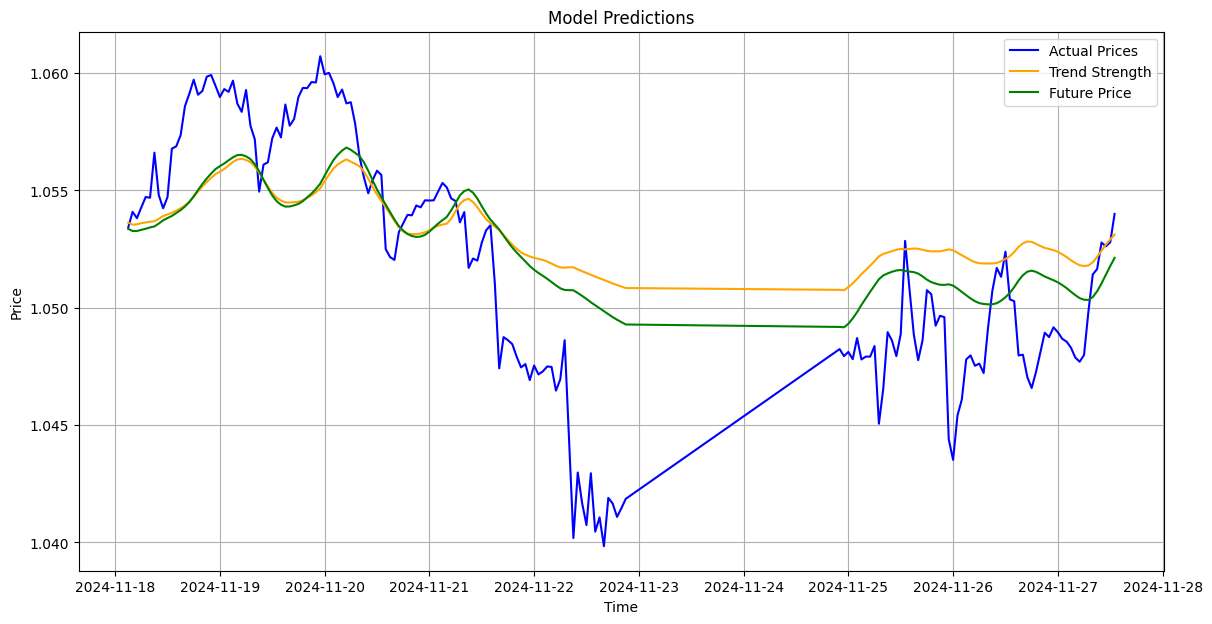

In [2]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
START_DATE = "2022-01-01"
GRANULARITY = "H1"

# Fetch Historical Data
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    params = {"granularity": granularity, "count": count}
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns, sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Build LSTM Model
def build_extended_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    shared = Dense(32, activation='relu')(x)

    # Output 1: Trend Strength
    trend_output = Dense(1, activation='linear', name='trend_strength')(shared)

    # Output 2: Reversal Probability
    reversal_output = Dense(1, activation='sigmoid', name='reversal_probability')(shared)

    # Output 3: Future Price
    future_price_output = Dense(1, activation='linear', name='future_price')(shared)

    model = Model(inputs=inputs, outputs=[trend_output, reversal_output, future_price_output])
    model.compile(optimizer='adam',
                  loss={
                      'trend_strength': 'mean_squared_error',
                      'reversal_probability': 'binary_crossentropy',
                      'future_price': 'mean_squared_error'
                  },
                  metrics={
                      'trend_strength': 'mae',
                      'reversal_probability': 'accuracy',
                      'future_price': 'mae'
                  })
    return model

# Visualize Results
def plot_results(data, predictions, title="Model Predictions"):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label="Actual Prices", color="blue")
    plt.plot(data['time'], predictions['trend_strength'], label="Trend Strength", color="orange")
    plt.plot(data['time'], predictions['future_price'], label="Future Price", color="green")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Workflow
if __name__ == "__main__":
    # Fetch data from OANDA
    data = fetch_oanda_data(instrument="EUR_USD", granularity=GRANULARITY, count=1000)

    if data.empty:
        print("No data fetched. Exiting.")
    else:
        # Calculate indicators
        data['RSI'] = calculate_rsi(data['close'])
        data['SMA_50'] = calculate_sma(data['close'], window=50)
        data['EMA_50'] = calculate_ema(data['close'], window=50)
        data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

        # Drop NaN values
        data.dropna(inplace=True)

        # Prepare features and target columns
        feature_columns = FEATURE_COLUMNS
        target_columns = [0]  # Target is close price (you can extend as needed)
        X, y, scaler = preprocess_data(data[feature_columns], target_columns)

        # Split data
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Train the model
        model = build_extended_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, [y_train, y_train, y_train], epochs=20, batch_size=32, validation_data=(X_test, [y_test, y_test, y_test]))

        # Save the model
        model.save("multi_output_lstm_model.h5")

        # Make predictions
        predictions = model.predict(X_test)

# ... (previous code) ...

# Rescale predictions
        trend_strength = scaler.inverse_transform(np.repeat(predictions[0], len(FEATURE_COLUMNS), axis=1))[:, 0]  # Reshape to match original features
        future_price = scaler.inverse_transform(np.repeat(predictions[2], len(FEATURE_COLUMNS), axis=1))[:, 0]  # Reshape to match original features

# Visualize
        plot_results(data.iloc[-len(X_test):], {'trend_strength': trend_strength, 'future_price': future_price})


Starting backtest...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Opening Buy position at 1.09772, Future Price Target: 1.0948039288127422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Closing Buy position at 1.09798 with profit 0.0012999999999996348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Opening Buy position at 1.09747, Future Price Target: 1.0951955332958698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Closing Buy position at 1.09761 with profit 0.000700000000000145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Opening Buy position at 1.0984, Future Price Target: 1.0954234928959607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Closing Buy position at 1.09823 with profit -0.0008500000000000174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Opening Buy position at 1.0969, Future Price Target: 1.0957385666304826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Closing Buy position at 1.09724 with profit 0.0017000000000000348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Opening Buy position at 1.09748, Future Price Target: 1.0956888496869803
1/1 ━━━━━

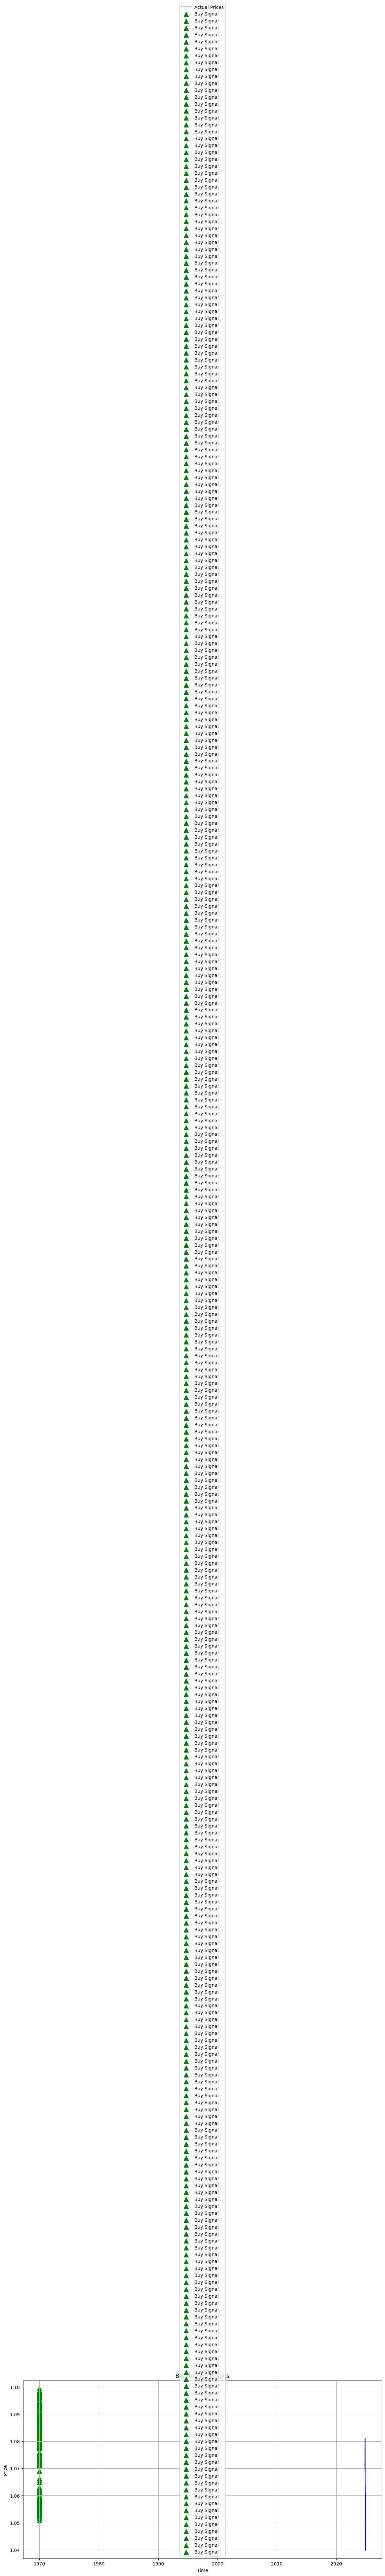

In [17]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
GRANULARITY = "H1"

# Fetch Historical Data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500):
    """
    Fetch historical price data from OANDA.
    """
    params = {
        "granularity": granularity,
        "count": count
    }
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data from OANDA: {e}")
        return pd.DataFrame()

# Calculate Technical Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns=[0], sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Backtesting Function
# def backtest(data, model, scaler):
#     print("Starting backtest...")
#     initial_balance = 100000  # Starting balance
#     balance = initial_balance
#     trades = []
#     position = None
#     entry_price = None

#     # Prepare data for backtesting
#     X, _, _ = preprocess_data(data[FEATURE_COLUMNS], target_columns=[0])  # Only prepare features

#     for i in range(len(X)):
#         # Predict using the model
#         predictions = model.predict(X[i].reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS)))
#         trend_strength, reversal_prob, future_price = predictions

#         # Rescale the future price prediction
#         temp_array = np.zeros((1, len(FEATURE_COLUMNS)))
#         temp_array[:, 0] = future_price.ravel()  # Assign future price to the 'close' column
#         rescaled_future_price = scaler.inverse_transform(temp_array)[:, 0]  # Rescale only the close column

#         # Get current price
#         current_price = data['close'].iloc[i + SEQUENCE_LENGTH]

#         # Determine trade logic
#         if position is None:  # No open position
#             if trend_strength > 0.6:
#                 position = "buy"
#                 entry_price = current_price
#                 trades.append({"action": "buy", "entry": entry_price, "exit": None, "profit": None})
#                 print(f"Opening Buy position at {current_price}")
#             elif trend_strength < 0.4:
#                 position = "sell"
#                 entry_price = current_price
#                 trades.append({"action": "sell", "entry": entry_price, "exit": None, "profit": None})
#                 print(f"Opening Sell position at {current_price}")

#         else:  # Position is open
#             if position == "buy" and (current_price >= rescaled_future_price or reversal_prob > 0.6):
#                 profit = current_price - entry_price
#                 balance += profit
#                 print(f"Closing Buy position at {current_price} with profit {profit}")
#                 trades[-1]["exit"] = current_price
#                 trades[-1]["profit"] = profit
#                 position = None
#             elif position == "sell" and (current_price <= rescaled_future_price or reversal_prob > 0.6):
#                 profit = entry_price - current_price
#                 balance += profit
#                 print(f"Closing Sell position at {current_price} with profit {profit}")
#                 trades[-1]["exit"] = current_price
#                 trades[-1]["profit"] = profit
#                 position = None

#     print(f"Final Balance: {balance}")
#     return trades, balance




# def backtest(data, model, scaler):
#     print("Starting backtest...")
#     initial_balance = 100000  # Starting balance
#     balance = initial_balance
#     trades = []
#     position = None
#     entry_price = None

#     # Prepare data for backtesting
#     X, _, _ = preprocess_data(data[FEATURE_COLUMNS], target_columns=[0])  # Only prepare features

#     for i in range(len(X)):
#         # Predict using the model
#         predictions = model.predict(X[i].reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS)))
#         trend_strength, reversal_prob, future_price = predictions

#         # Rescale the future price prediction
#         temp_array = np.zeros((1, len(FEATURE_COLUMNS)))
#         temp_array[:, 0] = future_price.ravel()  # Assign future price to the 'close' column
#         rescaled_future_price = scaler.inverse_transform(temp_array)[:, 0]  # Rescale only the close column

#         # Get current price
#         current_price = data['close'].iloc[i + SEQUENCE_LENGTH]

#         # Decision logic based on ML predictions
#         if position is None:  # No active position
#             if trend_strength > 0:  # Upward trend identified
#                 position = "buy"
#                 entry_price = current_price
#                 trades.append({"action": "buy", "entry": entry_price, "exit": None, "profit": None})
#                 print(f"Opening Buy position at {current_price}, Future Price Target: {rescaled_future_price[0]}")
#             elif trend_strength < 0:  # Downward trend identified
#                 position = "sell"
#                 entry_price = current_price
#                 trades.append({"action": "sell", "entry": entry_price, "exit": None, "profit": None})
#                 print(f"Opening Sell position at {current_price}, Future Price Target: {rescaled_future_price[0]}")
#         else:  # Position is already open
#             if position == "buy" and (reversal_prob > 0.5 or current_price >= rescaled_future_price[0]):
#                 # Exit buy position on trend reversal or reaching target price
#                 profit = current_price - entry_price
#                 balance += profit
#                 print(f"Closing Buy position at {current_price} with profit {profit}")
#                 trades[-1]["exit"] = current_price
#                 trades[-1]["profit"] = profit
#                 position = None
#             elif position == "sell" and (reversal_prob > 0.5 or current_price <= rescaled_future_price[0]):
#                 # Exit sell position on trend reversal or reaching target price
#                 profit = entry_price - current_price
#                 balance += profit
#                 print(f"Closing Sell position at {current_price} with profit {profit}")
#                 trades[-1]["exit"] = current_price
#                 trades[-1]["profit"] = profit
#                 position = None

#     print(f"Final Balance: {balance}")
#     return trades, balance



def backtest(data, model, scaler):
    print("Starting backtest...")
    initial_balance = 100000  # Starting balance
    balance = initial_balance
    trades = []
    position = None  # No initial position
    entry_price = None
    units = 5  # Buy/sell 5 units per trade

    # Prepare data for backtesting
    X, _, _ = preprocess_data(data[FEATURE_COLUMNS], target_columns=[0])  # Only prepare features

    for i in range(len(X)):
        # Predict using the model
        predictions = model.predict(X[i].reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS)))
        trend_strength, reversal_prob, future_price = predictions

        # Rescale the future price prediction
        temp_array = np.zeros((1, len(FEATURE_COLUMNS)))
        temp_array[:, 0] = future_price.ravel()  # Assign future price to the 'close' column
        rescaled_future_price = scaler.inverse_transform(temp_array)[:, 0]  # Rescale only the close column

        # Get current price
        current_price = data['close'].iloc[i + SEQUENCE_LENGTH]

        # Decision logic based on ML predictions
        if position is None:  # No active position
            if trend_strength > 0:  # Upward trend identified
                position = "buy"
                entry_price = current_price
                trades.append({"action": "buy", "entry": entry_price, "exit": None, "profit": None, "units": units})
                print(f"Opening Buy position at {current_price}, Future Price Target: {rescaled_future_price[0]}")
            elif trend_strength < 0:  # Downward trend identified
                position = "sell"
                entry_price = current_price
                trades.append({"action": "sell", "entry": entry_price, "exit": None, "profit": None, "units": units})
                print(f"Opening Sell position at {current_price}, Future Price Target: {rescaled_future_price[0]}")
        else:  # Position is already open
            if position == "buy" and (reversal_prob > 0.5 or current_price >= rescaled_future_price[0]):
                # Exit buy position on trend reversal or reaching target price
                profit = current_price - entry_price
                balance += profit * units
                print(f"Closing Buy position at {current_price} with profit {profit * units}")
                trades[-1]["exit"] = current_price
                trades[-1]["profit"] = profit * units
                position = None
            elif position == "sell" and (reversal_prob > 0.5 or current_price <= rescaled_future_price[0]):
                # Exit sell position on trend reversal or reaching target price
                profit = entry_price - current_price
                balance += profit * units
                print(f"Closing Sell position at {current_price} with profit {profit * units}")
                trades[-1]["exit"] = current_price
                trades[-1]["profit"] = profit * units
                position = None

    print(f"Final Balance: {balance}")
    return trades, balance





# Visualize Backtesting Results
def plot_results(data, trades, title="Backtesting Results"):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label="Actual Prices", color="blue")

    for trade in trades:
        if trade["action"] == "buy":
            plt.scatter(trade["entry"], trade["entry"], color="green", label="Buy Signal", marker="^", s=100)
        elif trade["action"] == "sell":
            plt.scatter(trade["entry"], trade["entry"], color="red", label="Sell Signal", marker="v", s=100)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Fetch data from OANDA
    data = fetch_oanda_data(instrument="EUR_USD", granularity=GRANULARITY, count=1000)
    if data.empty:
        print("No data fetched. Exiting.")
        exit()

    # Calculate indicators
    data['RSI'] = calculate_rsi(data['close'])
    data['SMA_50'] = calculate_sma(data['close'], window=50)
    data['EMA_50'] = calculate_ema(data['close'], window=50)
    data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

    # Drop NaN values
    data.dropna(inplace=True)

    # Load trained model
    model = load_model("multi_output_lstm_model.h5")

    # Run backtest
    trades, final_balance = backtest(data, model, MinMaxScaler().fit(data[FEATURE_COLUMNS]))

    # Plot results
    plot_results(data.iloc[-len(trades):], trades)


KeyError: 'time'

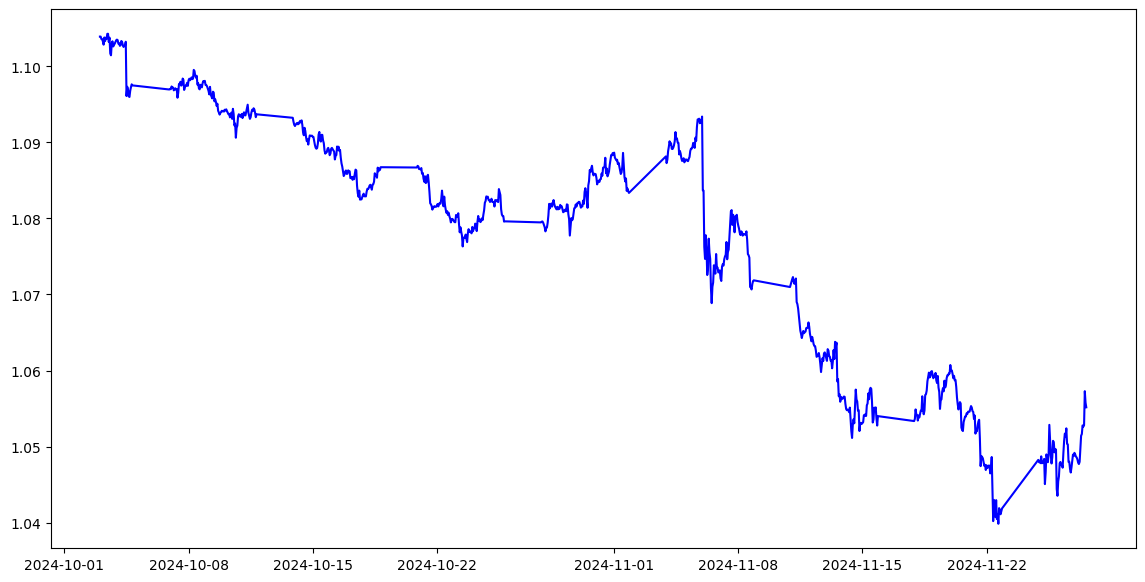

In [18]:
# Function to visualize results
def plot_trades(data, trades):
    plt.figure(figsize=(14, 7))

    # Plot close price
    plt.plot(data['time'], data['close'], label="Close Price", color='blue')

    # Plot buy/sell signals
    for trade in trades:
        if trade['action'] == "buy":
            plt.scatter(trade['time'], trade['entry'], color='green', label="Buy Signal", marker='^', s=100)
        elif trade['action'] == "sell":
            plt.scatter(trade['time'], trade['entry'], color='red', label="Sell Signal", marker='v', s=100)

    plt.title("Backtest with Buy/Sell Signals")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# After backtesting, you can call plot_trades to visualize
plot_trades(data, trades)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (951,) and (891, 1)

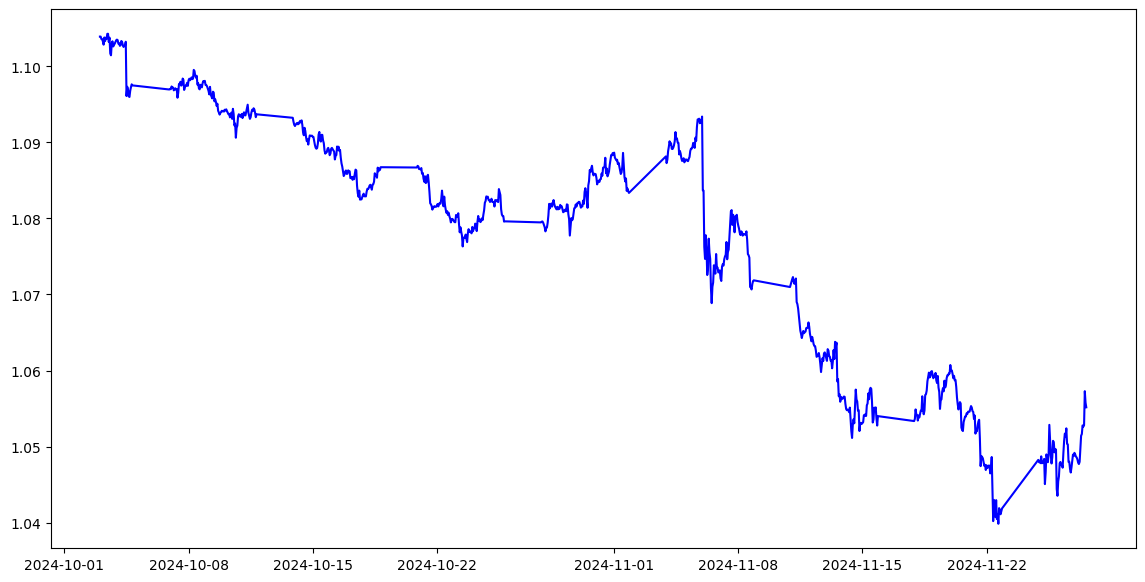

In [19]:
import matplotlib.pyplot as plt

def plot_predicted_trends(data, predicted_trends):
    """
    Plot the predicted trend against actual price data.

    Args:
    - data: DataFrame containing the actual market data (e.g., time and close price).
    - predicted_trends: List of predicted trend values from the ML model.
    """
    plt.figure(figsize=(14, 7))

    # Plot actual close price
    plt.plot(data['time'], data['close'], label="Actual Close Price", color='blue')

    # Plot predicted trend
    plt.plot(data['time'], predicted_trends, label="Predicted Trend", color='orange', linestyle='--')

    # Adding labels and title
    plt.title("Predicted Trend vs Actual Close Price")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

def live_trading():
    # Initialize lists for predictions and trades
    predicted_trends = []
    trades = []

    # Simulation loop (replace with actual live trading loop)
    for i in range(len(data) - SEQUENCE_LENGTH):  # Iterate over the data
        # Predict the trend using the model
        input_data = data[FEATURE_COLUMNS].values[i:i + SEQUENCE_LENGTH]
        input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
        predicted_trend = model.predict(input_data)

        # Append the predicted trend
        predicted_trends.append(predicted_trend[0][0])  # Assuming the trend is the first output

        # (Your logic for trading actions like Buy/Sell would go here)
        # For example, if predicted_trend > 0.5: Buy
        # If predicted_trend < 0.5: Sell

    # Plot the actual data vs predicted trends
    plot_predicted_trends(data, predicted_trends)

# Main execution: you can call live_trading to visualize the predicted trend
live_trading()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

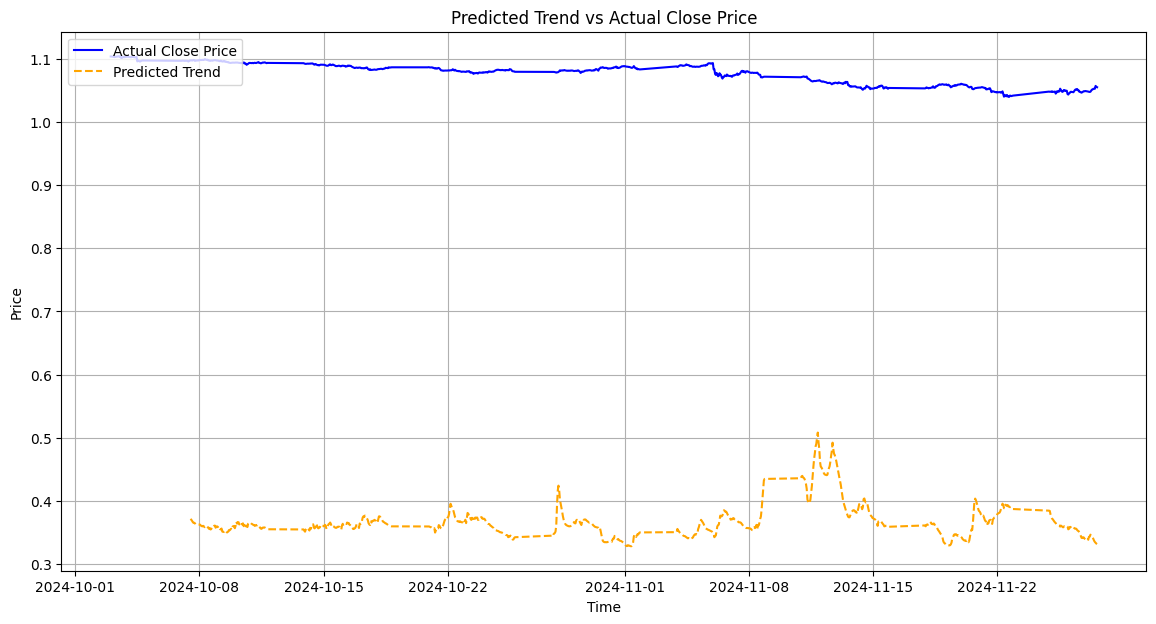

In [20]:
import matplotlib.pyplot as plt

def plot_predicted_trends(data, predicted_trends):
    """
    Plot the predicted trend against actual price data.

    Args:
    - data: DataFrame containing the actual market data (e.g., time and close price).
    - predicted_trends: List of predicted trend values from the ML model.
    """
    plt.figure(figsize=(14, 7))

    # Plot actual close price
    plt.plot(data['time'], data['close'], label="Actual Close Price", color='blue')

    # Plot predicted trend
    # Slice data['time'] to match the length of predicted_trends
    plt.plot(data['time'][SEQUENCE_LENGTH:], predicted_trends, label="Predicted Trend", color='orange', linestyle='--')

    # Adding labels and title
    plt.title("Predicted Trend vs Actual Close Price")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

def live_trading():
    # Initialize lists for predictions and trades
    predicted_trends = []
    trades = []

    # Simulation loop (replace with actual live trading loop)
    for i in range(len(data) - SEQUENCE_LENGTH):  # Iterate over the data
        # Predict the trend using the model
        input_data = data[FEATURE_COLUMNS].values[i:i + SEQUENCE_LENGTH]
        input_data = input_data.reshape(1, SEQUENCE_LENGTH, len(FEATURE_COLUMNS))
        predicted_trend = model.predict(input_data)

        # Append the predicted trend
        predicted_trends.append(predicted_trend[0][0])  # Assuming the trend is the first output

        # (Your logic for trading actions like Buy/Sell would go here)
        # For example, if predicted_trend > 0.5: Buy
        # If predicted_trend < 0.5: Sell

    # Plot the actual data vs predicted trends
    plot_predicted_trends(data, predicted_trends)

# Main execution: you can call live_trading to visualize the predicted trend
live_trading()

# Predicted trend

In [22]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
START_DATE = "2022-01-01"
GRANULARITY = "H1"

# Fetch Historical Data
def fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500):
    params = {"granularity": granularity, "count": count}
    try:
        endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
        client.request(endpoint)
        candles = endpoint.response["candles"]

        records = []
        for candle in candles:
            records.append({
                "time": candle["time"],
                "open": float(candle["mid"]["o"]),
                "high": float(candle["mid"]["h"]),
                "low": float(candle["mid"]["l"]),
                "close": float(candle["mid"]["c"]),
            })

        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate Indicators
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess Data
def preprocess_data(data, target_columns, sequence_length=SEQUENCE_LENGTH):
    if data.empty:
        raise ValueError("Dataset is empty. Cannot preprocess.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Features
        y.append(scaled_data[i, target_columns])   # Targets
    return np.array(X), np.array(y), scaler

# Define the backtesting function
def backtest():
    # Fetch historical data
    data = fetch_oanda_data(instrument="EUR_USD", granularity="H1", count=500)
    if data.empty:
        print("No data fetched for backtesting. Exiting.")
        return

    # Calculate indicators
    data['RSI'] = calculate_rsi(data['close'])
    data['SMA_50'] = calculate_sma(data['close'], window=50)
    data['EMA_50'] = calculate_ema(data['close'], window=50)
    data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

    # Drop NaN values
    data.dropna(inplace=True)

    # Prepare features and target
    feature_columns = FEATURE_COLUMNS
    target_columns = [0]  # Target is close price (you can extend as needed)
    X, y, scaler = preprocess_data(data[feature_columns], target_columns)

    # Load the model
    try:
        model = load_model("multi_output_lstm_model.h5")
        print("Model loaded successfully!")
    except:
        print("No model found. Please train the model first.")
        return

    # Simulating Trades
    balance = 100000
    position = None
    trade_entry_price = None
    trades = []  # To store trade information

    for i in range(len(X)):
        # Get predicted trend for the current time step
        prediction = model.predict(X[i].reshape(1, X[i].shape[0], X[i].shape[1]))

        # Get current price
        current_price = data['close'].iloc[i + SEQUENCE_LENGTH]  # Ensure we get data aligned with predictions
        predicted_trend = prediction[0][0]  # Trend strength
        predicted_future_price = prediction[2][0]  # Future price

        # Print predictions and current price
        print(f"Predicted Trend: {predicted_trend}, Predicted Future Price: {predicted_future_price}, Current Price: {current_price}")

        # Check if there is an open position and close it based on profit/loss
        if position:
            # Check if stop-loss or take-profit is hit
            if position == "buy" and current_price >= trade_entry_price + (0.005):  # Example TP
                print(f"Take profit hit. Closing Buy at {current_price}")
                balance += (current_price - trade_entry_price) * 1000  # Units = 1000
                position = None
            elif position == "sell" and current_price <= trade_entry_price - (0.005):  # Example TP
                print(f"Take profit hit. Closing Sell at {current_price}")
                balance += (trade_entry_price - current_price) * 1000
                position = None
            elif current_price <= trade_entry_price - (0.005):  # Example SL
                print(f"Stop loss hit. Closing position at {current_price}")
                balance -= (trade_entry_price - current_price) * 1000
                position = None

        # Open new position if none exists
        if not position:
            if predicted_trend > 0.6:  # Buy if trend strength is high
                print(f"Buying at {current_price}")
                position = "buy"
                trade_entry_price = current_price
                balance -= trade_entry_price * 1000
            elif predicted_trend < 0.4:  # Sell if trend strength is low
                print(f"Selling at {current_price}")
                position = "sell"
                trade_entry_price = current_price
                balance += trade_entry_price * 1000

        trades.append({
            'balance': balance,
            'position': position,
            'entry_price': trade_entry_price,
            'current_price': current_price
        })

    # Print final balance after backtesting
    print(f"Final Balance after backtesting: {balance}")
    return trades


# Main execution
if __name__ == "__main__":
    trades = backtest()
    if trades:
        # Optionally, visualize trades
        for trade in trades:
            print(f"Balance: {trade['balance']} | Position: {trade['position']} | Entry Price: {trade['entry_price']} | Current Price: {trade['current_price']}")


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Trend: [0.88516045], Predicted Future Price: [0.8836619], Current Price: 1.08918
Buying at 1.08918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Trend: [0.895284], Predicted Future Price: [0.894477], Current Price: 1.0894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted Trend: [0.9068966], Predicted Future Price: [0.90699613], Current Price: 1.08994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Trend: [0.9182625], Predicted Future Price: [0.91936326], Current Price: 1.08958
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Trend: [0.9266158], Predicted Future Price: [0.92859477], Current Price: 1.08928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted Trend: [0.93420184], Predicted Future Price: [0.93686014], Current Price: 1.09062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Trend: [0.9421846], Predicted Future Price: [0.9450271], Current Price: 1.09021
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Trend: 

In [25]:
import oandapyV20
import oandapyV20.endpoints.pricing as pricing
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from datetime import datetime

# OANDA API Credentials
# OANDA API Credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Constants
SEQUENCE_LENGTH = 60  # Length of data used for prediction
FEATURE_COLUMNS = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
MODEL_PATH = "multi_output_lstm_model.h5"

# Initialize variables for visualization
prices = []
predicted_trends = []
times = []

# Fetch Historical Data (for initial processing)
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    params = {"granularity": granularity, "count": count, "instruments": instrument}
    try:
        endpoint = pricing.PricingInfo(accountID=ACCOUNT_ID, params=params)
        client.request(endpoint)
        data = endpoint.response["prices"]
        records = []
        for item in data:
            records.append({
                "time": item["time"],
                "close": float(item["closeoutBid"])
            })
        df = pd.DataFrame(records)
        df["time"] = pd.to_datetime(df["time"])
        return df
    except Exception as e:
        print(f"Error fetching data for {instrument}: {e}")
        return pd.DataFrame()

# Calculate RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate SMA
def calculate_sma(prices, window):
    return prices.rolling(window=window).mean()

# Calculate EMA
def calculate_ema(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

# Calculate Bollinger Bands
def calculate_bollinger_bands(prices, window=20):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return sma, upper_band, lower_band

# Preprocess data for prediction
def preprocess_data(data, sequence_length=SEQUENCE_LENGTH):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X = []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])

    return np.array(X), scaler

# Load the trained model
def load_trained_model():
    try:
        model = load_model(MODEL_PATH)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Predict trend using the trained model
def predict_trend(model, data, sequence_length=SEQUENCE_LENGTH):
    input_data = data[-sequence_length:].reshape(1, sequence_length, len(FEATURE_COLUMNS))
    prediction = model.predict(input_data)
    return prediction[0][0]  # Trend strength

# Visualize live data and predicted trend
def plot_live_data(prices, predicted_trends, times):
    plt.figure(figsize=(14, 7))
    plt.plot(times, prices, label="Price", color='blue')
    plt.plot(times, predicted_trends, label="Predicted Trend", color='orange', linestyle='--')
    plt.title("Live Trading Data with Predicted Trends")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Simulate placing a trade (visualization only)
def place_trade(predicted_trend, current_price, times):
    if predicted_trend > 0.6:
        print(f"Buy signal at {current_price}")
        plt.scatter(times[-1], current_price, color='green', label="Buy Signal", marker='^', s=100)
    elif predicted_trend < 0.4:
        print(f"Sell signal at {current_price}")
        plt.scatter(times[-1], current_price, color='red', label="Sell Signal", marker='v', s=100)

# Main loop for live trading and visualization
def live_trading():
    model = load_trained_model()

    if model is None:
        return

    while True:
        try:
            # Fetch new data from OANDA every minute (1-minute candles)
            live_data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=SEQUENCE_LENGTH + 100)
            if live_data.empty:
                print("Insufficient live data. Skipping this cycle.")
                time.sleep(60)
                continue

            # Append new prices and times to the global lists
            prices.append(live_data['close'].iloc[-1])
            times.append(live_data['time'].iloc[-1])

            # Calculate indicators
            live_data['RSI'] = calculate_rsi(live_data['close'])
            live_data['SMA_50'] = calculate_sma(live_data['close'], window=50)
            live_data['EMA_50'] = calculate_ema(live_data['close'], window=50)
            live_data['BB_Mid'], live_data['BB_Upper'], live_data['BB_Lower'] = calculate_bollinger_bands(live_data['close'])

            # Drop NaN values caused by indicators
            live_data.dropna(inplace=True)

            # Ensure we have enough data for predictions
            if len(live_data) < SEQUENCE_LENGTH:
                print("Insufficient processed data. Skipping this cycle.")
                time.sleep(60)
                continue

            # Prepare model input
            X, scaler = preprocess_data(live_data[FEATURE_COLUMNS])

            # Predict the trend
            predicted_trend = predict_trend(model, X)
            predicted_trends.append(predicted_trend)

            # Plot data and predicted trend
            plot_live_data(prices, predicted_trends, times)

            # Place trades based on the model's predicted trend
            place_trade(predicted_trend, live_data['close'].iloc[-1], times)

        except Exception as e:
            print(f"Error during live trading: {e}")

        # Wait before the next cycle
        time.sleep(60)

# Main execution
if __name__ == "__main__":
    live_trading()


Model loaded successfully!
Insufficient processed data. Skipping this cycle.
Insufficient processed data. Skipping this cycle.
Insufficient processed data. Skipping this cycle.
Insufficient processed data. Skipping this cycle.


KeyboardInterrupt: 

# RL

In [4]:
!pip install oandapyV20
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install stable-baselines3[extra]
!pip install stable-baselines3
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.3 MB/s eta 0:00:00


In [11]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# OANDA API credentials
ACCESS_TOKEN = "c18f86851d4bc0df6484465cc421b291-0cfa37fe32e0bd236d25613eb716b95e"
ACCOUNT_ID = "101-004-30239848-002"
client = oandapyV20.API(access_token=ACCESS_TOKEN)

# Define the trading environment class
class TradingEnvironment:
    def __init__(self, data, action_space=3, max_steps=200):
        self.data = data
        self.action_space = action_space  # [buy, sell, hold]
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 100000  # Initial balance
        self.position = None  # No open position at the start
        self.entry_price = 0
        self.done = False
        self.total_profit = 0
        return self.get_state()

    def get_state(self):
        state = self.data[self.current_step]  # The market data for current step
        return np.array(state)

    def step(self, action):
        # Execute the action (buy, sell, hold)
        current_price = self.data[self.current_step][3]  # Close price
        reward = 0
        if action == 0:  # Buy
            if self.position is None:
                self.position = "buy"
                self.entry_price = current_price
        elif action == 1:  # Sell
            if self.position == "buy":
                reward = current_price - self.entry_price  # Profit or loss
                self.balance += reward
                self.position = None
        elif action == 2:  # Hold
            pass  # No action, just hold

        # Calculate total profit
        self.total_profit = self.balance - 100000

        # Check if the episode ends (e.g., maximum steps reached)
        self.current_step += 1
        if self.current_step >= len(self.data) or self.total_profit <= -5000:  # Stop if max loss occurs
            self.done = True

        return self.get_state(), reward, self.done, {}

    def render(self):
        print(f"Balance: {self.balance}, Total Profit: {self.total_profit}")

# Fetch historical data from OANDA
def fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500):
    params = {
        "granularity": granularity,
        "count": count
    }
    endpoint = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = client.request(endpoint)
    candles = response["candles"]

    records = []
    for candle in candles:
        records.append({
            "time": candle["time"],
            "open": float(candle["mid"]["o"]),
            "high": float(candle["mid"]["h"]),
            "low": float(candle["mid"]["l"]),
            "close": float(candle["mid"]["c"]),
        })

    df = pd.DataFrame(records)
    df["time"] = pd.to_datetime(df["time"])
    return df

# Preprocess data for the model (normalize prices and indicators)
# def preprocess_data(data, sequence_length=60):
#     scaler = MinMaxScaler()
#     scaled_data = scaler.fit_transform(data[['open', 'high', 'low', 'close']].values)  # Scale price data
#     state = []
#     for i in range(sequence_length, len(scaled_data)):
#         state.append(scaled_data[i-sequence_length:i])
#     return np.array(state), scaler



def preprocess_data(data, target_column, sequence_length=60):
    # Ensure data contains expected columns
    required_columns = ['open', 'high', 'low', 'close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Missing required columns: {set(required_columns) - set(data.columns)}")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[required_columns].values)  # Scale all columns

    state = []
    target = []  # List to store target values
    for i in range(sequence_length, len(scaled_data)):
        state.append(scaled_data[i - sequence_length:i])
        # Extract and append the target value (e.g., 'close' price)
        target.append(scaled_data[i, target_column])  # Assuming target_column is the index of the target column

    return np.array(state), np.array(target), scaler  # Return X, y, and scaler

# Define the training function
def train_model(data):
    env = DummyVecEnv([lambda: TradingEnvironment(data)])  # Wrap environment
    model = PPO("MlpPolicy", env, verbose=1)  # Use PPO algorithm for training
    model.learn(total_timesteps=10000)  # Train for 10,000 timesteps
    return model

# Define the backtesting function
# ... (previous code)

# Define the backtesting function
def backtest():
    # Fetch historical data
    data = fetch_oanda_data(instrument="EUR_USD", granularity="M1", count=500)
    if data.empty:
        print("No data fetched for backtesting. Exiting.")
        return

    # Preprocessing data
    data['RSI'] = calculate_rsi(data['close'])
    data['SMA_50'] = calculate_sma(data['close'], window=50)
    data['EMA_50'] = calculate_ema(data['close'], window=50)
    data['BB_Mid'], data['BB_Upper'], data['BB_Lower'] = calculate_bollinger_bands(data['close'])

    # Drop NaN values
    data.dropna(inplace=True)

    # Prepare features and target - **USE THE SAME FEATURES THAT WERE USED FOR TRAINING**
    # feature_columns = ['close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']  # This should match training features
    feature_columns = ['open', 'high', 'low', 'close', 'RSI', 'SMA_50', 'EMA_50', 'BB_Mid', 'BB_Upper', 'BB_Lower']  # Updated features
    target_column = feature_columns.index('close') # Predict 'close' price by getting its index in the columns
    X, y, scaler = preprocess_data(data[feature_columns], target_column)

    # Load or Train the Model
    try:
        model = load_model("multi_output_lstm_model.h5")
        print("Model loaded successfully!")
    except:
        print("No model found. Please train the model first.")
        return

    # ... (rest of your backtesting logic)

    # Simulating Trades
    balance = 100000
    position = None
    trade_entry_price = None
    trades = []  # To store trade information

    for i in range(len(X)):
        # Get predicted trend for the current time step
        prediction = model.predict(X[i].reshape(1, X[i].shape[0], X[i].shape[1]))

        # Get current price
        current_price = data['close'].iloc[i + 60]  # Ensure we get data aligned with predictions
        predicted_trend = prediction[0][0]
        print(f"Predicted Trend: {predicted_trend}, Current Price: {current_price}")

        # Check if there is an open position and close it based on profit/loss
        if position:
            # Check if stop-loss or take-profit is hit
            if position == "buy" and current_price >= trade_entry_price + (SLIPPAGE * 3):
                print(f"Take profit hit. Closing Buy at {current_price}")
                balance += (current_price - trade_entry_price) * UNITS - TRANSACTION_COST
                position = None
            elif position == "sell" and current_price <= trade_entry_price - (SLIPPAGE * 3):
                print(f"Take profit hit. Closing Sell at {current_price}")
                balance += (trade_entry_price - current_price) * UNITS - TRANSACTION_COST
                position = None
            elif current_price <= trade_entry_price - (SLIPPAGE * 3):  # Stop loss hit
                print(f"Stop loss hit. Closing position at {current_price}")
                balance -= (trade_entry_price - current_price) * UNITS + TRANSACTION_COST
                position = None

        # Open new position if none exists
        if not position:
            if predicted_trend > current_price:
                print(f"Buying at {current_price}")
                position = "buy"
                trade_entry_price = current_price
                balance -= trade_entry_price * UNITS + TRANSACTION_COST
            elif predicted_trend < current_price:
                print(f"Selling at {current_price}")
                position = "sell"
                trade_entry_price = current_price
                balance += trade_entry_price * UNITS - TRANSACTION_COST

        trades.append({
            'balance': balance,
            'position': position,
            'entry_price': trade_entry_price,
            'current_price': current_price
        })

    # Print final balance after backtesting
    print(f"Final Balance after backtesting: {balance}")
    return trades


# Main execution
if __name__ == "__main__":
    trades = backtest()
    if trades:
        # Optionally, visualize trades
        for trade in trades:
            print(f"Balance: {trade['balance']} | Position: {trade['position']} | Entry Price: {trade['entry_price']} | Current Price: {trade['current_price']}")


Model loaded successfully!


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 60, 7), found shape=(1, 60, 10)